# Job Search

**Prepared for the Bank of Portugal Computational Economics Course (Oct 2025)**

**Author:** [John Stachurski](https://johnstachurski.net)


In this lecture we study a basic infinite-horizon job search problem with Markov wage
draws 

* For background on infinite horizon job search see, e.g., [DP1](https://dp.quantecon.org/).


In addition to what's in Anaconda, this lecture will need the QE library:

In [1]:
#!pip install quantecon  # Uncomment if necessary

We use the following imports.

In [2]:
import matplotlib.pyplot as plt
import quantecon as qe
import jax.numpy as jnp
import jax
from jax import lax
import time
from typing import NamedTuple, Callable
from functools import partial

## Model

We study an elementary model where 

* jobs are permanent 
* unemployed workers receive current compensation $c$
* the horizon is infinite
* an unemployment agent discounts the future via discount factor $\beta \in (0,1)$

### Set up

At the start of each period, an unemployed worker receives wage offer $W_t$.

We assume that 

$$
    \ln W_{t+1} = \rho \ln W_t + \nu Z_{t+1}
$$

where $(Z_t)_{t \geq 0}$ is IID and standard normal.

We then discretize this wage process using Tauchen's method to produce a stochastic matrix $P$.

Successive wage offers are drawn from $P$.

### Rewards

Since jobs are permanent, the return to accepting wage offer $w$ today is

$$
    w + \beta w + \beta^2 w + 
    \cdots = \frac{w}{1-\beta}
$$

The Bellman equation is

$$
    v(w) = \max
    \left\{
            \frac{w}{1-\beta}, c + \beta \sum_{w'} v(w') P(w, w')
    \right\}
$$

We solve this model using value function iteration.

## Code

Let's set up a `Model` class to store information needed to solve the model.

In [3]:
class Model(NamedTuple):
    n: int
    w_vals: jnp.ndarray
    P: jnp.ndarray
    β: float
    c: float

The function below holds default values and creates a `Model` instance.

In [4]:
def create_js_model(
        n: int = 500,       # wage grid size
        ρ: float = 0.9,     # wage persistence
        ν: float = 0.2,     # wage volatility
        β: float = 0.99,    # discount factor
        c: float = 1.0,     # unemployment compensation
    ) -> Model:
    "Creates an instance of the job search model with Markov wages."
    mc = qe.tauchen(n, ρ, ν)
    w_vals, P = jnp.exp(mc.state_values), jnp.array(mc.P)
    return Model(n, w_vals, P, β, c)

Let's test it:

In [5]:
model = create_js_model(β=0.98)

In [6]:
model.c

1.0

In [7]:
model.β

0.98

In [8]:
model.w_vals.mean()  

Array(1.3486148, dtype=float32)

Here's the Bellman operator

$$
    (Tv)(w) = \max
    \left\{
            \frac{w}{1-\beta}, c + \beta \sum_{w'} v(w') P(w, w')
    \right\}
$$

In [9]:
@jax.jit
def T(v: jnp.ndarray, model: Model) -> jnp.ndarray:
    """
    The Bellman operator Tv = max{e, c + β P v} with

        e(w) = w / (1-β) and (Pv)(w) = E_w[ v(W')]

    """
    n, w_vals, P, β, c = model
    h = c + β * P @ v
    e = w_vals / (1 - β)

    return jnp.maximum(e, h)

The next function computes the optimal policy under the assumption that $v$ is
the value function.

The policy takes the form

$$
    \sigma(w) = \mathbf 1 
        \left\{
            \frac{w}{1-\beta} \geq c + \beta \sum_{w'} v(w') P(w, w')
        \right\}
$$

Here $\mathbf 1$ is an indicator function.

* $\sigma(w) = 1$ means stop
* $\sigma(w) = 0$ means continue.

In [10]:
@jax.jit
def get_greedy(v: jnp.ndarray, model: Model) -> jnp.ndarray:
    "Get a v-greedy policy."
    n, w_vals, P, β, c = model
    e = w_vals / (1 - β)
    h = c + β * P @ v
    σ = jnp.where(e >= h, 1, 0)
    return σ

Here's a routine for value function iteration.

In [11]:
def vfi(
        model: Model,
        max_iter: int = 10_000,
        tol: float = 1e-4,
        verbose: bool = False
    ):
    """
    Solve the infinite-horizon Markov job search model by VFI.

    """
    v = jnp.zeros_like(model.w_vals)  # Initial condition

    for i in range(max_iter):
        new_v = T(v, model)
        error = jnp.max(jnp.abs(new_v - v))
        if error < tol:
            if verbose:
                print(f"VFI converged after {i+1} iterations "
                      f"(error: {error:.2e})")
            break
        v = new_v
    else:
        print(f"VFI hit max iterations ({max_iter}) with error {error:.2e}")

    return new_v, get_greedy(new_v, model)

## Computing the solution

Let's set up and solve the model.

In [12]:
model = create_js_model()
n, w_vals, P, β, c = model

v_star, σ_star = vfi(model, verbose=True)

VFI converged after 441 iterations (error: 9.16e-05)


Here's the optimal policy:

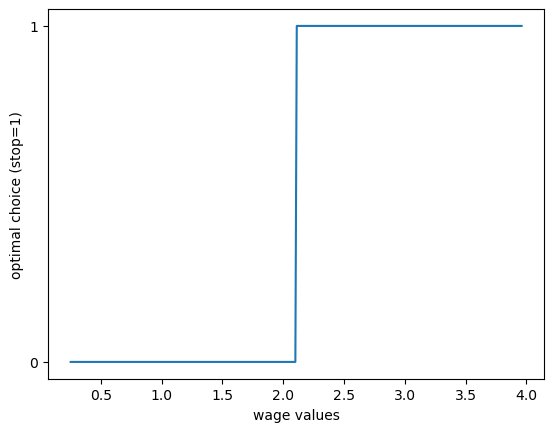

In [13]:
fig, ax = plt.subplots()
ax.plot(w_vals, σ_star)
ax.set_xlabel("wage values")
ax.set_ylabel("optimal choice (stop=1)")
ax.set_yticks((0, 1))
plt.show()

Let's compute the runtime as well, averaging over a number of iterations

In [14]:
runtimes = []
for _ in range(10):
    start = time.time()
    v_star, σ_star = vfi(model, verbose=False)
    end = time.time()
    runtimes.append(end - start)

print()
mean_runtime = jnp.mean(jnp.array(runtimes))
print(f"Mean runtime for value function iteration = {mean_runtime:.4f} seconds")
print()


Mean runtime for value function iteration = 0.3419 seconds



We compute the reservation wage as the first $w$ such that $\sigma(w)=1$.

In [15]:
stop_indices = jnp.where(σ_star == 1)
stop_indices

(Array([385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397,
        398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410,
        411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423,
        424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
        437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449,
        450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,
        463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
        476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488,
        489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499],      dtype=int32),)

In [16]:
res_wage_index = min(stop_indices[0])

In [17]:
res_wage = w_vals[res_wage_index]

Here's a joint plot of the value function and the reservation wage.

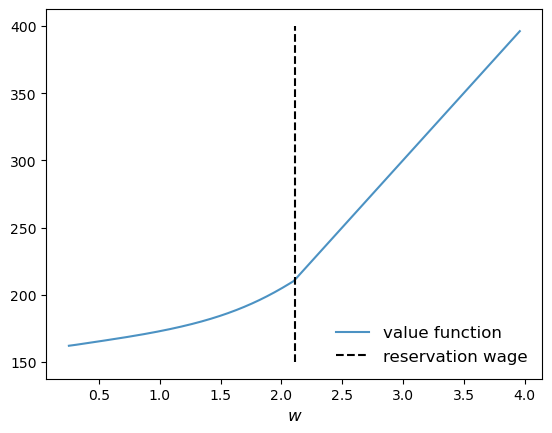

In [18]:
fig, ax = plt.subplots()
ax.plot(w_vals, v_star, alpha=0.8, label="value function")
ax.vlines((res_wage,), 150, 400, 'k', ls='--', label="reservation wage")
ax.legend(frameon=False, fontsize=12, loc="lower right")
ax.set_xlabel("$w$", fontsize=12)
plt.show()

## Exercise 1

In the setting above, the agent is risk-neutral vis-a-vis future utility risk.

Now solve the same problem but this time assuming that the agent has risk-sensitive
preferences, which are a type of nonlinear recursive preferences.

The Bellman equation becomes

$$
    v(w) = \max
    \left\{
            \frac{w}{1-\beta}, 
            c + \frac{\beta}{\theta}
            \ln \left[ 
                      \sum_{w'} \exp(\theta v(w')) P(w, w')
                \right]
    \right\}
$$


When $\theta < 0$ the agent is risk averse.

Solve the model when $\theta = -0.1$ and compare your result to the risk neutral
case.

Try to interpret your result.

You can start with the following code:

In [19]:
class RiskModel(NamedTuple):
    n: int
    w_vals: jnp.ndarray
    P: jnp.ndarray
    β: float
    c: float
    θ: float

def create_risk_sensitive_js_model(
        n: int = 500,       # wage grid size
        ρ: float = 0.9,     # wage persistence
        ν: float = 0.2,     # wage volatility
        β: float = 0.99,    # discount factor
        c: float = 1.0,     # unemployment compensation
        θ: float = -0.1     # risk parameter
    ) -> RiskModel:
    "Creates an instance of the job search model with Markov wages."
    mc = qe.tauchen(n, ρ, ν)
    w_vals, P = jnp.exp(mc.state_values), jnp.array(mc.P)
    return RiskModel(n, w_vals, P, β, c, θ)

Now you need to modify `T` and `get_greedy` and then run value function iteration again.

In [20]:
# Put your code here

In [21]:
for _ in range(20):
    print("Solution below!")

Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!


In [22]:
@jax.jit
def T_rs(v: jnp.ndarray, model: RiskModel) -> jnp.ndarray:
    """
    The Bellman operator Tv = max{e, c + β R v} with

        e(w) = w / (1-β) and

        (Rv)(w) = (1/θ) ln{E_w[ exp(θ v(W'))]}

    """
    n, w_vals, P, β, c, θ = model
    h = c + (β / θ) * jnp.log(P @ (jnp.exp(θ * v)))
    e = w_vals / (1 - β)

    return jnp.maximum(e, h)


@jax.jit
def get_greedy_rs(v: jnp.ndarray, model: RiskModel) -> jnp.ndarray:
    " Get a v-greedy policy."
    n, w_vals, P, β, c, θ = model
    e = w_vals / (1 - β)
    h = c + (β / θ) * jnp.log(P @ (jnp.exp(θ * v)))
    σ = jnp.where(e >= h, 1, 0)
    return σ


def vfi_rs(
        model: RiskModel,
        max_iter: int = 10_000,
        tol: float = 1e-4
    ):
    "Solve the infinite-horizon Markov job search model by VFI."
    v = jnp.zeros_like(model.w_vals)

    for i in range(max_iter):
        new_v = T_rs(v, model)
        error = jnp.max(jnp.abs(new_v - v))
        if error < tol:
            print(f"VFI converged after {i+1} iterations (error: {error:.2e})")
            break
        v = new_v
    else:
        print(f"VFI reached max iterations ({max_iter}) with error {error:.2e}")

    return new_v, get_greedy_rs(new_v, model)

In [23]:
model_rs = create_risk_sensitive_js_model()
n, w_vals, P, β, c, θ = model_rs
v_star_rs, σ_star_rs = vfi_rs(model_rs)

VFI converged after 579 iterations (error: 9.16e-05)


Let's plot the results together with the original risk neutral case and see what we get.

In [24]:
stop_indices = jnp.where(σ_star_rs == 1)
res_wage_index = min(stop_indices[0])
res_wage_rs = w_vals[res_wage_index]

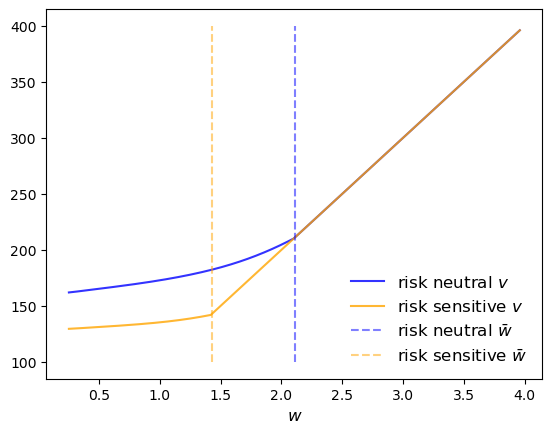

In [25]:
fig, ax = plt.subplots()
ax.plot(w_vals, v_star,  ls='-', color='blue',
        alpha=0.8, label="risk neutral $v$")
ax.plot(w_vals, v_star_rs, ls='-', color='orange',
        alpha=0.8, label="risk sensitive $v$")
ax.vlines((res_wage,), 100, 400,  ls='--', color='blue',
          alpha=0.5, label=r"risk neutral $\bar w$")
ax.vlines((res_wage_rs,), 100, 400, ls='--', color='orange',
          alpha=0.5, label=r"risk sensitive $\bar w$")
ax.legend(frameon=False, fontsize=12, loc="lower right")
ax.set_xlabel("$w$", fontsize=12)
plt.show()

The figure shows that the reservation wage under risk sensitive preferences (RS $\bar w$) shifts down.

This makes sense -- the agent does not like risk and hence is more inclined to
accept the current offer, even when it's lower.

## Exercise 2

In the code above, we wrote two versions of VFI, one for each model.

This is poor style because we are repeating logic.  

Write one version of VFI that can work with both and test that it does the
same job.

In [26]:
# Put your code here

In [27]:
for _ in range(20):
    print("Solution below!")

Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!


In [28]:
def generic_vfi(
        bellman_operator: Callable,
        get_greedy_function: Callable,
        v_zero: jnp.ndarray,
        max_iter: int = 10_000,
        tol: float = 1e-4
    ):
    """
    Solve the infinite-horizon Markov job search model by VFI.

    """
    v = v_zero

    for i in range(max_iter):
        new_v = bellman_operator(v)
        error = jnp.max(jnp.abs(new_v - v))
        if error < tol:
            print(f"VFI converged after {i+1} iterations (error: {error:.2e})")
            break
        v = new_v
    else:
        print(f"VFI reached max iterations ({max_iter}) with error {error:.2e}")

    return new_v, get_greedy_function(new_v)

## Fully JIT-compiled VFI with lax.while_loop

This version uses JAX's `lax.while_loop` for maximum performance with early termination.

In [29]:
@partial(jax.jit, static_argnums=(0, 1))
def compiled_generic_vfi(
        bellman_operator: Callable,
        get_greedy_function: Callable,
        v_zero: jnp.ndarray,
        max_iter: int = 10_000,
        tol: float = 1e-4
    ):
    """
    Solve the infinite-horizon Markov job search model by VFI.

    """
    v = v_zero
    i = 0
    error = tol + 1
    initial_loop_state = i, error, v

    def condition(loop_state):
        i, error, v = loop_state
        return jnp.logical_and(error > tol, i < max_iter)

    def update(loop_state):
        i, error, v = loop_state
        new_i = i + 1
        new_v = bellman_operator(v)
        new_error = jnp.max(jnp.abs(new_v - v))
        return new_i, new_error, new_v

    final_loop_state = jax.lax.while_loop(condition, update, initial_loop_state)
    i, error, v = final_loop_state
    return v, get_greedy_function(v)

Let's compare speed.

In [30]:
model = create_js_model()
n, w_vals, P, β, c = model
v_star_0, σ_star_0 = vfi(model)
bellman_operator = lambda v: T(v, model)
get_greedy_function = lambda v: get_greedy(v, model)
v_zero = jnp.zeros_like(w_vals)

# Time the non-compiled version
start_time = time.time()
v_star, σ_star = generic_vfi(
    bellman_operator, get_greedy_function, v_zero
)
jax.block_until_ready(v_star)  # Wait for computation to complete
non_compiled_time = time.time() - start_time
print(f"Non-compiled generic VFI time: {non_compiled_time:.4f} seconds")

# Run the compiled version -- warm up to eliminate compile time
v_star_compiled, σ_star_compiled = compiled_generic_vfi(
    bellman_operator, get_greedy_function, v_zero
)

# Time the compiled version (now pre-compiled)
start_time = time.time()
v_star_compiled, σ_star_compiled = compiled_generic_vfi(
    bellman_operator, get_greedy_function, v_zero
)
jax.block_until_ready(v_star_compiled)  # Wait for computation to complete
compiled_time = time.time() - start_time
print(f"Compiled generic VFI time: {compiled_time:.4f} seconds")

print(f"Speedup vs non-compiled: {non_compiled_time / compiled_time:.2f}x")

VFI converged after 441 iterations (error: 9.16e-05)
Non-compiled generic VFI time: 0.1630 seconds
Compiled generic VFI time: 0.0146 seconds
Speedup vs non-compiled: 11.14x
